In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:


root = 'data/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
test_df = pd.read_csv(root + 'test.csv')
test_df["hour"] = pd.to_datetime(test_df["timestamp"], format='%Y-%m-%d %H:%M:%S').dt.hour

weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

In [10]:
print("buildings:", building_meta_df.shape)
print("weather points", weather_train_df.shape)

buildings: (1449, 6)
weather points (139773, 9)


In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [12]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [14]:
train_df.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype=object)

In [15]:
test_df.columns.values

array(['row_id', 'building_id', 'meter', 'timestamp'], dtype=object)

In [17]:
weather_train_df.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

In [18]:
weather_test_df.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

In [20]:
building_meta_df.columns.values

array(['site_id', 'building_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count'], dtype=object)

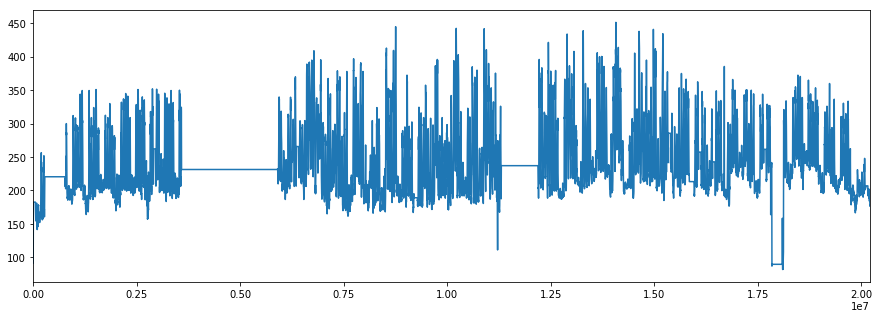

In [20]:
plt.figure(figsize = (15,5))
train_df.query('building_id==108 and meter==0')['meter_reading'].plot()
plt.show()

In [86]:
train_df.query('building_id==608 and meter==0 and meter_reading!=0')[['timestamp','meter_reading']].shape

(8783, 2)

In [91]:
sample_submission.shape

(41697600, 2)

## Basic model

We need to build a predictive model that needs to predict a meter measurement for a given input: (building_id, meter_id, date_time) --> meter_measurement

For the baseline_1 we may take into account (building_id, meter_id, time). No info about whether or season (date) will be considered.

All zero values or NaNs should be ignored.

In [93]:
train_clean_df = train_df[train_df['meter_reading']!=0]

In [94]:
train_clean_df.shape

(18342124, 4)

In [102]:
train_clean_df['time'] = train_clean_df['timestamp'].dt.hour

In [115]:
clean_df = train_clean_df.drop(['timestamp'], axis=1)

In [121]:
clean_res = clean_df.groupby(['building_id', 'meter', 'time'])['meter_reading'].mean()

In [129]:
clean_res[0,0,23]

239.4065

In [137]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [204]:
submission = test_df
submission['meter_reading'] = 0.0

In [205]:
submission = submission.drop(['timestamp'], axis=1)
sub = submission.as_matrix()

/Users/ian/anaconda2/envs/net/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [206]:
print("updating...")
for i in range(len(sub)):
    if i %10000000 == 0:
        print(i)
    _,b,m,h,_ = sub[i]
    sub[i,4] = clean_res.get((b,m,h), 10)
print('done')

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000


In [222]:
submission = pd.DataFrame(sub)

In [223]:
submission.head()

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,238.683746
1,1.0,1.0,0.0,0.0,116.730064
2,2.0,2.0,0.0,0.0,12.866715
3,3.0,3.0,0.0,0.0,367.774048
4,4.0,4.0,0.0,0.0,1528.743652


In [226]:
del submission[3]

In [235]:
submission = submission.rename(columns={0:'row_id', 4:'meter_reading'})
submission.head()

,row_id,meter_reading
0,0.0,238.683746
1,1.0,116.730064
2,2.0,12.866715
3,3.0,367.774048
4,4.0,1528.743652


In [236]:
submission = submission.astype({'row_id': int})

In [238]:
submission.to_csv("submission.csv", index=False)

In [228]:
sample_submission.head()rfeadefsadzaqa5a\

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [237]:
submission.head()

,row_id,meter_reading
0,0,238.683746
1,1,116.730064
2,2,12.866715
3,3,367.774048
4,4,1528.743652


# Model 1. 
Let us explore how many building we have in our train_dataset and test_dataset

In [245]:
# number of unique buildings in train dataset

len(set(train_df.building_id))

1449

In [247]:
# in test dataset

len(set(test_df.building_id))

1449

In [248]:
# 
len(clean_res)

57068

In [253]:
len(test_df[['building_id', 'meter', 'hour']])

41697600

In [254]:
# so we have little observation for (bild_id, meter, hour)

In [288]:
submission = test_df
submission['meter_reading'] = 0.0
submission = submission.drop(['timestamp'], axis=1)
sub = submission.as_matrix()

/Users/ian/anaconda2/envs/net/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [289]:
print("updating...")
for i in range(len(sub)):
    if i %10000000 == 0:
        print(i)
    _,b,m,h,_ = sub[i]
    val = clean_res.get((b,m,h), None)
    if val:
        sub[i,4] = val
    else:
        val = clean_res.get((b,m), 20*np.ones(2))
        sub[i,4] = val.mean()
            
print('done')

updating...
0
10000000
20000000
30000000
40000000
done


In [290]:
submission = pd.DataFrame(sub)
submission.head()

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,238.683746
1,1.0,1.0,0.0,0.0,116.730064
2,2.0,2.0,0.0,0.0,12.866715
3,3.0,3.0,0.0,0.0,367.774048
4,4.0,4.0,0.0,0.0,1528.743652


In [293]:
del submission[3]

In [294]:
submission = submission.rename(columns={0:'row_id', 4: 'meter_reading'})
submission.head()

,row_id,meter_reading
0,0.0,238.683746
1,1.0,116.730064
2,2.0,12.866715
3,3.0,367.774048
4,4.0,1528.743652


In [281]:
sample_submission.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [295]:
submission = submission.astype({'row_id': int})

In [296]:
submission.to_csv("submission2.csv", index=False)

In [297]:
submission.tail(10)

,row_id,meter_reading
41697590,41697590,281.388184
41697591,41697591,281.999298
41697592,41697592,79.129204
41697593,41697593,51.171906
41697594,41697594,92.789551
41697595,41697595,6.918515
41697596,41697596,5.356371
41697597,41697597,8.309163
41697598,41697598,173.622513
41697599,41697599,3.908710


In [5]:
sample_submission['meter_reading'] = 300
sample_submission.tail()

,row_id,meter_reading
41697595,41697595,300
41697596,41697596,300
41697597,41697597,300
41697598,41697598,300
41697599,41697599,300


In [298]:
submission.tail()

,row_id,meter_reading
41697595,41697595,6.918515
41697596,41697596,5.356371
41697597,41697597,8.309163
41697598,41697598,173.622513
41697599,41697599,3.908710
